## Import modules and libraries

In [1181]:
from utils_data_preparation import *
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [1182]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [1183]:
def timedelta_with_general_date(df, general_date=None, drop = True):
    dates = df.select_dtypes('datetime').columns
    dates = set(dates) - set([general_date])
    for i in dates:
        df['Diff_days'+general_date +'_bt_'+ i] = (df[general_date] - df[i]).astype('timedelta64[D]')
        df['Diff_month'+general_date +'_bt_'+ i] = (df[general_date] - df[i]).astype('timedelta64[M]')
        df['Diff_year'+general_date +'_bt_'+ i] = (df[general_date] - df[i]).astype('timedelta64[Y]')
    if drop: df.drop(dates, axis=1, inplace=True)
    return df

## Train

### Load data

In [1184]:
df_train = pd.read_csv(path/'Train.csv', parse_dates=['Policy Start Date','Policy End Date',
                                                     'First Transaction Date'])

In [1185]:
df_train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [1186]:
df_train.shape

(12079, 14)

In [1187]:
df_train.describe()

,Age,No_Pol,target
count,12079.00000,12079.00000,12079.00000
mean,42.23454,1.30723,0.12046
std,97.49256,0.73308,0.32551
min,-6099.00000,1.00000,0.00000
25%,35.00000,1.00000,0.00000
50%,41.00000,1.00000,0.00000
75%,50.00000,1.00000,0.00000
max,320.00000,10.00000,1.00000


In [1188]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12079 non-null  object        
 1   Policy Start Date       12079 non-null  datetime64[ns]
 2   Policy End Date         12079 non-null  datetime64[ns]
 3   Gender                  11720 non-null  object        
 4   Age                     12079 non-null  int64         
 5   First Transaction Date  12079 non-null  datetime64[ns]
 6   No_Pol                  12079 non-null  int64         
 7   Car_Category            8341 non-null   object        
 8   Subject_Car_Colour      5117 non-null   object        
 9   Subject_Car_Make        9603 non-null   object        
 10  LGA_Name                5603 non-null   object        
 11  State                   5591 non-null   object        
 12  ProductName             12079 non-null  object

In [1189]:
min(df_train['Policy Start Date'])

Timestamp('2001-12-11 00:00:00')

In [1190]:
max(df_train['Policy Start Date'])

Timestamp('2010-12-31 00:00:00')

### Train/val split

In [1191]:
df_train.sort_values(by= 'Policy Start Date', inplace = True)

In [1192]:
df_train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
8010,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,NaN,NaN,Car Vintage,0
10526,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0
10234,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41,2003-04-13,2,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,0
12066,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,NaN,BMW,NaN,NaN,Car Vintage,0
8124,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44,2005-08-05,1,NaN,NaN,Tata,Ajah,Lagos,CVTP,0


In [1193]:
df_train.reset_index(inplace =True, drop = True)

In [1194]:
n = round(len(df_train) * 0.8)
df_train,df_val = split_vals(df_train,n)

In [1195]:
df_train.shape

(9663, 14)

In [1196]:
df_val.shape

(2416, 14)

In [1197]:
df_train['target'].value_counts()

0    8423
1    1240
Name: target, dtype: int64

In [1198]:
df_val['target'].value_counts()

0    2201
1     215
Name: target, dtype: int64

In [1199]:
df_train.reset_index(inplace = True, drop = True)

In [1200]:
df_train.to_feather(path/'data/processed/train.fth')

In [1201]:
df_val.reset_index(inplace = True, drop = True)
df_val.to_feather(path/'data/processed/val.fth')

### Data preparation

#### Adding timedelta

In [1202]:
timedelta_with_general_date(df_train, 'Policy Start Date',drop = False)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date
0,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,NaN,NaN,Car Vintage,0,-3651.00000,-120.00000,-10.00000,0.00000,0.00000,0.00000
1,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0,-3286.00000,-108.00000,-9.00000,0.00000,0.00000,0.00000
2,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41,2003-04-13,2,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,0,-2921.00000,-96.00000,-8.00000,0.00000,0.00000,0.00000
3,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,NaN,BMW,NaN,NaN,Car Vintage,0,-11108.00000,-365.00000,-31.00000,0.00000,0.00000,0.00000
4,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44,2005-08-05,1,NaN,NaN,Tata,Ajah,Lagos,CVTP,0,-2246.00000,-74.00000,-7.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,ID_H9LG7PR,2010-10-22,2011-10-21,Male,32,2010-10-22,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,1,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
9659,ID_TTLEPUP,2010-10-22,2011-01-20,Female,38,2010-10-22,1,Saloon,Green,TOYOTA,NaN,NaN,Car Classic,1,-90.00000,-3.00000,-1.00000,0.00000,0.00000,0.00000
9660,ID_SQQ0Q3O,2010-10-22,2011-02-18,Male,53,2010-10-22,1,JEEP,Green,TOYOTA,Ikeja,Lagos,Car Classic,0,-119.00000,-4.00000,-1.00000,0.00000,0.00000,0.00000
9661,ID_Z5ONJVD,2010-10-22,2011-10-21,Male,2,2010-10-22,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000


#### Add datepart

In [1203]:
date_cols = df_train.select_dtypes(include = ['datetime64[ns]']).columns

In [1204]:
for date in date_cols:
    add_datepart(df_train,date,drop=False)

In [1205]:
date_cols

Index(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], dtype='object')

In [1206]:
df_train.drop(columns = date_cols, inplace = True)

#### Encode categoricals

In [1207]:
cat_cols = df_train.drop(columns='ID').select_dtypes(include=['object']).columns

In [1208]:
cat_cols

Index(['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName'],
      dtype='object')

In [1209]:
CatPrep = EncodeCategorical(df_train[cat_cols].columns)

In [1210]:
df_train[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,Female,Saloon,Black,Honda,NaN,NaN,Car Vintage
1,Male,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic
2,Male,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage
3,Male,Saloon,NaN,BMW,NaN,NaN,Car Vintage
4,Female,NaN,NaN,Tata,Ajah,Lagos,CVTP


In [1211]:
CatPrep(df_train)

In [1212]:
df_train[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,2,9,5,25,0,0,4
1,4,9,5,64,70,23,2
2,4,9,5,64,109,71,4
3,4,9,0,8,0,0,4
4,2,0,0,65,22,71,1


In [1213]:
CatPrep.save(path/'CatPrep.pkl')

#### Fill Missing

In [1214]:
num_cols = df_train.drop(columns=['target']).select_dtypes(exclude=['object','datetime64[ns]']).columns

In [1215]:
num_cols

Index(['First Transaction Week', 'Policy End Week', 'Policy Start Week',
       'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName',
       'Diff_daysPolicy Start Date_bt_Policy End Date',
       'Diff_monthPolicy Start Date_bt_Policy End Date',
       'Diff_yearPolicy Start Date_bt_Policy End Date',
       'Diff_daysPolicy Start Date_bt_First Transaction Date',
       'Diff_monthPolicy Start Date_bt_First Transaction Date',
       'Diff_yearPolicy Start Date_bt_First Transaction Date',
       'Policy Start Year', 'Policy Start Month', 'Policy Start Day',
       'Policy Start Dayofweek', 'Policy Start Dayofyear',
       'Policy Start Is_month_end', 'Policy Start Is_month_start',
       'Policy Start Is_quarter_end', 'Policy Start Is_quarter_start',
       'Policy Start Is_year_end', 'Policy Start Is_year_start',
       'Policy Start Weekend', 'Policy Start Season', 'Policy Start Elapsed',
       'Policy End Year

In [1216]:
missing_columns = df_train[num_cols].loc[:,df_train.isnull().sum()>0].columns

In [1217]:
missing_columns

Index([], dtype='object')

In [1218]:
df_train.isnull().sum().sum()

0

#### Save ready_train

In [1219]:
df_train.reset_index(inplace = True, drop = True)

In [1220]:
df_train.head()

,ID,First Transaction Week,Policy End Week,Policy Start Week,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Policy Start Year,Policy Start Month,Policy Start Day,Policy Start Dayofweek,Policy Start Dayofyear,Policy Start Is_month_end,Policy Start Is_month_start,Policy Start Is_quarter_end,Policy Start Is_quarter_start,Policy Start Is_year_end,Policy Start Is_year_start,Policy Start Weekend,Policy Start Season,Policy Start Elapsed,Policy End Year,Policy End Month,Policy End Day,Policy End Dayofweek,Policy End Dayofyear,Policy End Is_month_end,Policy End Is_month_start,Policy End Is_quarter_end,Policy End Is_quarter_start,Policy End Is_year_end,Policy End Is_year_start,Policy End Weekend,Policy End Season,Policy End Elapsed,First Transaction Year,First Transaction Month,First Transaction Day,First Transaction Dayofweek,First Transaction Dayofyear,First Transaction Is_month_end,First Transaction Is_month_start,First Transaction Is_quarter_end,First Transaction Is_quarter_start,First Transaction Is_year_end,First Transaction Is_year_start,First Transaction Weekend,First Transaction Season,First Transaction Elapsed
0,ID_O51ZQ1B,50,49,50,2,37,1,9,5,25,0,0,4,0,-3651.00000,-120.00000,-10.00000,0.00000,0.00000,0.00000,2001,12,11,1,345,False,False,False,False,False,False,0.00000,1,1008028800.00000,2011,12,10,5,344,False,False,False,False,False,False,1.00000,1,1323475200.00000,2001,12,11,1,345,False,False,False,False,False,False,0.00000,1,1008028800.00000
1,ID_VJ1FAVO,13,12,13,4,37,1,9,5,64,70,23,2,0,-3286.00000,-108.00000,-9.00000,0.00000,0.00000,0.00000,2002,3,25,0,84,False,False,False,False,False,False,0.00000,2,1017014400.00000,2011,3,24,3,83,False,False,False,False,False,False,0.00000,2,1300924800.00000,2002,3,25,0,84,False,False,False,False,False,False,0.00000,2,1017014400.00000
2,ID_ULWS8VL,15,15,15,4,41,2,9,5,64,109,71,4,0,-2921.00000,-96.00000,-8.00000,0.00000,0.00000,0.00000,2003,4,13,6,103,False,False,False,False,False,False,1.00000,2,1050192000.00000,2011,4,12,1,102,False,False,False,False,False,False,0.00000,2,1302566400.00000,2003,4,13,6,103,False,False,False,False,False,False,1.00000,2,1050192000.00000
3,ID_ZYKGSP7,51,20,51,4,48,2,9,0,8,0,0,4,0,-11108.00000,-365.00000,-31.00000,0.00000,0.00000,0.00000,2003,12,21,6,355,False,False,False,False,False,False,1.00000,1,1071964800.00000,2034,5,20,5,140,False,False,False,False,False,False,1.00000,2,2031696000.00000,2003,12,21,6,355,False,False,False,False,False,False,1.00000,1,1071964800.00000
4,ID_OEWBKGF,31,39,31,2,44,1,0,0,65,22,71,1,0,-2246.00000,-74.00000,-7.00000,0.00000,0.00000,0.00000,2005,8,5,4,217,False,False,False,False,False,False,0.00000,3,1123200000.00000,2011,9,29,3,272,False,False,False,False,False,False,0.00000,4,1317254400.00000,2005,8,5,4,217,False,False,False,False,False,False,0.00000,3,1123200000.00000


In [1221]:
df_train.to_csv(path/'data/ready/train.fth')

##### Data prep validation set

#### Adding timedelta

In [1222]:
timedelta_with_general_date(df_val, 'Policy Start Date',drop = False)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date
0,ID_B213Q4X,2010-10-22,2010-12-31,NaN,38,2010-10-22,1,JEEP,NaN,TOYOTA,Victoria Island,Lagos,Customized Motor,0,-70.00000,-3.00000,-1.00000,0.00000,0.00000,0.00000
1,ID_PFJYCCB,2010-10-22,2011-10-21,Male,35,2010-10-22,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
2,ID_RXPS7HI,2010-10-22,2011-09-07,Female,50,2010-10-22,1,NaN,NaN,NaN,NaN,NaN,Car Classic,0,-320.00000,-11.00000,-1.00000,0.00000,0.00000,0.00000
3,ID_IIIGSCQ,2010-10-22,2011-10-21,Female,20,2010-10-22,3,NaN,Black,Audi,Lekki,Lagos,Customized Motor,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
4,ID_3VZ77M5,2010-10-22,2011-10-19,Male,39,2010-10-22,4,NaN,NaN,NaN,Akwa Ibom,Akwa-Ibom,Car Classic,0,-362.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,ID_MLGO8DZ,2010-12-31,2011-06-30,Male,51,2010-12-31,4,Saloon,Black,Honda,Victoria Island,Lagos,Car Classic,0,-181.00000,-6.00000,-1.00000,0.00000,0.00000,0.00000
2412,ID_62LBOWI,2010-12-31,2011-12-30,Male,44,2010-12-31,1,NaN,NaN,NaN,Victoria Island,Lagos,Car Classic,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
2413,ID_XR8F115,2010-12-31,2011-12-30,Male,37,2010-12-31,1,JEEP,NaN,Hyundai,NaN,NaN,CarSafe,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
2414,ID_8P2UGYO,2010-12-31,2011-12-30,Male,20,2010-12-31,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000


In [1223]:
date_cols = df_val.select_dtypes(include = ['datetime64[ns]']).columns

In [1224]:
for date in date_cols:
    add_datepart(df_val,date,drop=False)

In [1225]:
date_cols

Index(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], dtype='object')

In [1226]:
df_val.drop(columns = date_cols, inplace = True)

#### Encode categoricals

In [1227]:
with open(path/'CatPrep.pkl', 'rb') as f:
    EncodeCategorical = pickle.load(f)

In [1228]:
df_val.drop(columns='ID').select_dtypes(include='object').head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,NaN,JEEP,NaN,TOYOTA,Victoria Island,Lagos,Customized Motor
1,Male,NaN,NaN,NaN,NaN,NaN,CarSafe
2,Female,NaN,NaN,NaN,NaN,NaN,Car Classic
3,Female,NaN,Black,Audi,Lekki,Lagos,Customized Motor
4,Male,NaN,NaN,NaN,Akwa Ibom,Akwa-Ibom,Car Classic


In [1229]:
for i in list(EncodeCategorical.categories):
    if i not in df_val.columns:
        EncodeCategorical.categories.pop(i)
EncodeCategorical.cat_names = list(EncodeCategorical.categories)

In [1230]:
EncodeCategorical(df_val,test=True)

In [1231]:
df_val[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,0,3,0,64,235,71,7
1,4,0,0,0,0,0,6
2,2,0,0,0,0,0,2
3,2,0,5,7,153,71,7
4,4,0,0,0,31,14,2


#### Fixmissing

In [1232]:
# with open(path/'FixMiss.pkl', 'rb') as f:
#     FixMiss = pickle.load(f)

In [1233]:
df_val.isnull().sum().sum()

0

#### Save ready_val

In [1234]:
df_val.reset_index(inplace = True, drop = True)

In [1235]:
df_val.head()

,ID,First Transaction Week,Policy End Week,Policy Start Week,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date,Policy Start Year,Policy Start Month,Policy Start Day,Policy Start Dayofweek,Policy Start Dayofyear,Policy Start Is_month_end,Policy Start Is_month_start,Policy Start Is_quarter_end,Policy Start Is_quarter_start,Policy Start Is_year_end,Policy Start Is_year_start,Policy Start Weekend,Policy Start Season,Policy Start Elapsed,Policy End Year,Policy End Month,Policy End Day,Policy End Dayofweek,Policy End Dayofyear,Policy End Is_month_end,Policy End Is_month_start,Policy End Is_quarter_end,Policy End Is_quarter_start,Policy End Is_year_end,Policy End Is_year_start,Policy End Weekend,Policy End Season,Policy End Elapsed,First Transaction Year,First Transaction Month,First Transaction Day,First Transaction Dayofweek,First Transaction Dayofyear,First Transaction Is_month_end,First Transaction Is_month_start,First Transaction Is_quarter_end,First Transaction Is_quarter_start,First Transaction Is_year_end,First Transaction Is_year_start,First Transaction Weekend,First Transaction Season,First Transaction Elapsed
0,ID_B213Q4X,42,52,42,0,38,1,3,0,64,235,71,7,0,-70.00000,-3.00000,-1.00000,0.00000,0.00000,0.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2010,12,31,4,365,True,False,True,False,True,False,0.00000,1,1293753600.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
1,ID_PFJYCCB,42,42,42,4,35,1,0,0,0,0,0,6,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,10,21,4,294,False,False,False,False,False,False,0.00000,4,1319155200.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
2,ID_RXPS7HI,42,36,42,2,50,1,0,0,0,0,0,2,0,-320.00000,-11.00000,-1.00000,0.00000,0.00000,0.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,9,7,2,250,False,False,False,False,False,False,0.00000,4,1315353600.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
3,ID_IIIGSCQ,42,42,42,2,20,3,0,5,7,153,71,7,0,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,10,21,4,294,False,False,False,False,False,False,0.00000,4,1319155200.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000
4,ID_3VZ77M5,42,42,42,4,39,4,0,0,0,31,14,2,0,-362.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000,2011,10,19,2,292,False,False,False,False,False,False,0.00000,4,1318982400.00000,2010,10,22,4,295,False,False,False,False,False,False,0.00000,4,1287705600.00000


In [1236]:
df_val.to_csv(path/'data/ready/val.fth')

## Modelling

In [1237]:
X_train = df_train.drop(columns = ['ID','target'], axis=1)
y_train = df_train.target

In [1238]:
X_val = df_val.drop(columns = ['ID','target'], axis=1)
y_val = df_val.target

#### Random Forest

In [1239]:
m = RandomForestClassifier(n_jobs=-1, n_estimators = 200, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.2680412371134021


array([[2080,  121],
       [ 163,   52]])

#### Balanced RF

In [1240]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 200, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3708609271523179


array([[1678,  523],
       [  47,  168]])

In [1241]:
for i in range(5):
    m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 200, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
    print(f'Training model')
    m.fit(X_train, y_train)
    y_pred =  m.predict(X_val)
    print(f'f1 score {f1_score(y_val,y_pred)}')
    confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3662597114317425
Training model
f1 score 0.3815937149270483
Training model
f1 score 0.35921205098493625
Training model
f1 score 0.37727272727272726
Training model
f1 score 0.36302895322939865


In [1242]:
for i in range(5):
    m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
    print(f'Training model')
    m.fit(X_train, y_train)
    y_pred =  m.predict(X_val)
    print(f'f1 score {f1_score(y_val,y_pred)}')
    confusion_matrix(y_val,y_pred)

Training model
f1 score 0.37254901960784315
Training model
f1 score 0.36303630363036304
Training model
f1 score 0.3648351648351648
Training model
f1 score 0.36666666666666664
Training model
f1 score 0.37849944008958564


##### Hyperparameter tuning

In [1243]:
#Minsamples

In [1244]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 1,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3674832962138085


array([[1683,  518],
       [  50,  165]])

In [1245]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 2,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.37336244541484714


array([[1671,  530],
       [  44,  171]])

In [1246]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.36155606407322655


array([[1700,  501],
       [  57,  158]])

In [1247]:
#Max features

In [1248]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 1.0)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.36363636363636365


array([[1696,  505],
       [  55,  160]])

In [1249]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.5)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.36111111111111116


array([[1649,  552],
       [  46,  169]])

In [1250]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 'sqrt')
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3201376936316695


array([[1440,  761],
       [  29,  186]])

In [1251]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 'log2')
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.31010452961672474


array([[1446,  755],
       [  37,  178]])

In [1252]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3
                                ,
                           criterion='entropy',
                           max_features= 0.9
                                  )
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.36423841059602646


array([[1675,  526],
       [  50,  165]])

#### Feature importance

In [1253]:
from utils_interpretation import *

In [1254]:
fi = rf_feat_importance(m, X_train)
fi[:40]

,feature,importance
11,ProductName,0.20720
4,Age,0.11125
9,LGA_Name,0.07347
8,Subject_Car_Make,0.06161
34,Policy End Day,0.05570
7,Subject_Car_Colour,0.05305
10,State,0.04054
20,Policy Start Day,0.03282
48,First Transaction Day,0.03212
45,Policy End Elapsed,0.03075


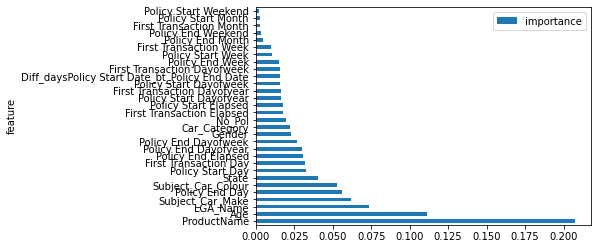

In [1255]:
plot_fi(fi[:30]);

In [1256]:
to_keep = fi[fi.importance>0.005].feature
len(to_keep)

25

In [1257]:
X_train = X_train[to_keep]

In [1258]:
X_val = X_val[to_keep]

In [1259]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9
                                  )
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.36363636363636365


array([[1660,  541],
       [  47,  168]])

#### Remove correlated feats

In [1260]:
def corr_drop(corr_m, factor=.9):
    """
    Drop correlated features maintaining the most relevant.
    
    Parameters
    ----------
    corr_m : pandas.DataFrame
        Correlation matrix
    factor : float
        Min correlation level   
    
    Returns
    ----------
    pandas.DataFrame
        Correlation matrix only with most relevant features
    """
    global cm
    cm = corr_m
    # Get correlation score, as high as this score, more chances to be dropped.
    cum_corr = cm.applymap(abs).sum()
    def remove_corr():
        global cm
        for col in cm.columns:
            for ind in cm.index:
                if (ind in cm.columns) and (col in cm.index):
                    # Compare if are high correlated.
                    if (cm.loc[ind,col] > factor) and (ind!=col):
                        cum = cum_corr[[ind,col]].sort_values(ascending=False)
                        cm.drop(cum.index[0], axis=0, inplace=True)
                        cm.drop(cum.index[0], axis=1, inplace=True)
                        # Do recursion until the last high correlated.
                        remove_corr()
        return cm
    return remove_corr()

In [1261]:
to_keep = corr_drop(X_train[to_keep].corr(method = 'spearman',min_periods = 2), 0.99).columns

In [1262]:
len(to_keep)

19

In [1263]:
to_keep

Index(['ProductName', 'Age', 'LGA_Name', 'Subject_Car_Make', 'Policy End Day',
       'Subject_Car_Colour', 'State', 'First Transaction Day',
       'Policy End Elapsed', 'Policy End Dayofyear', 'Policy End Dayofweek',
       'Gender', 'Car_Category', 'No_Pol', 'Policy Start Elapsed',
       'Diff_daysPolicy Start Date_bt_Policy End Date',
       'First Transaction Dayofweek', 'Policy End Week',
       'First Transaction Week'],
      dtype='object')

In [1264]:
X_train = X_train[to_keep]

In [1265]:
X_val = X_val[to_keep]

In [1266]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3756906077348066


array([[1681,  520],
       [  45,  170]])

In [1267]:
import scipy
from scipy.cluster import hierarchy as hc

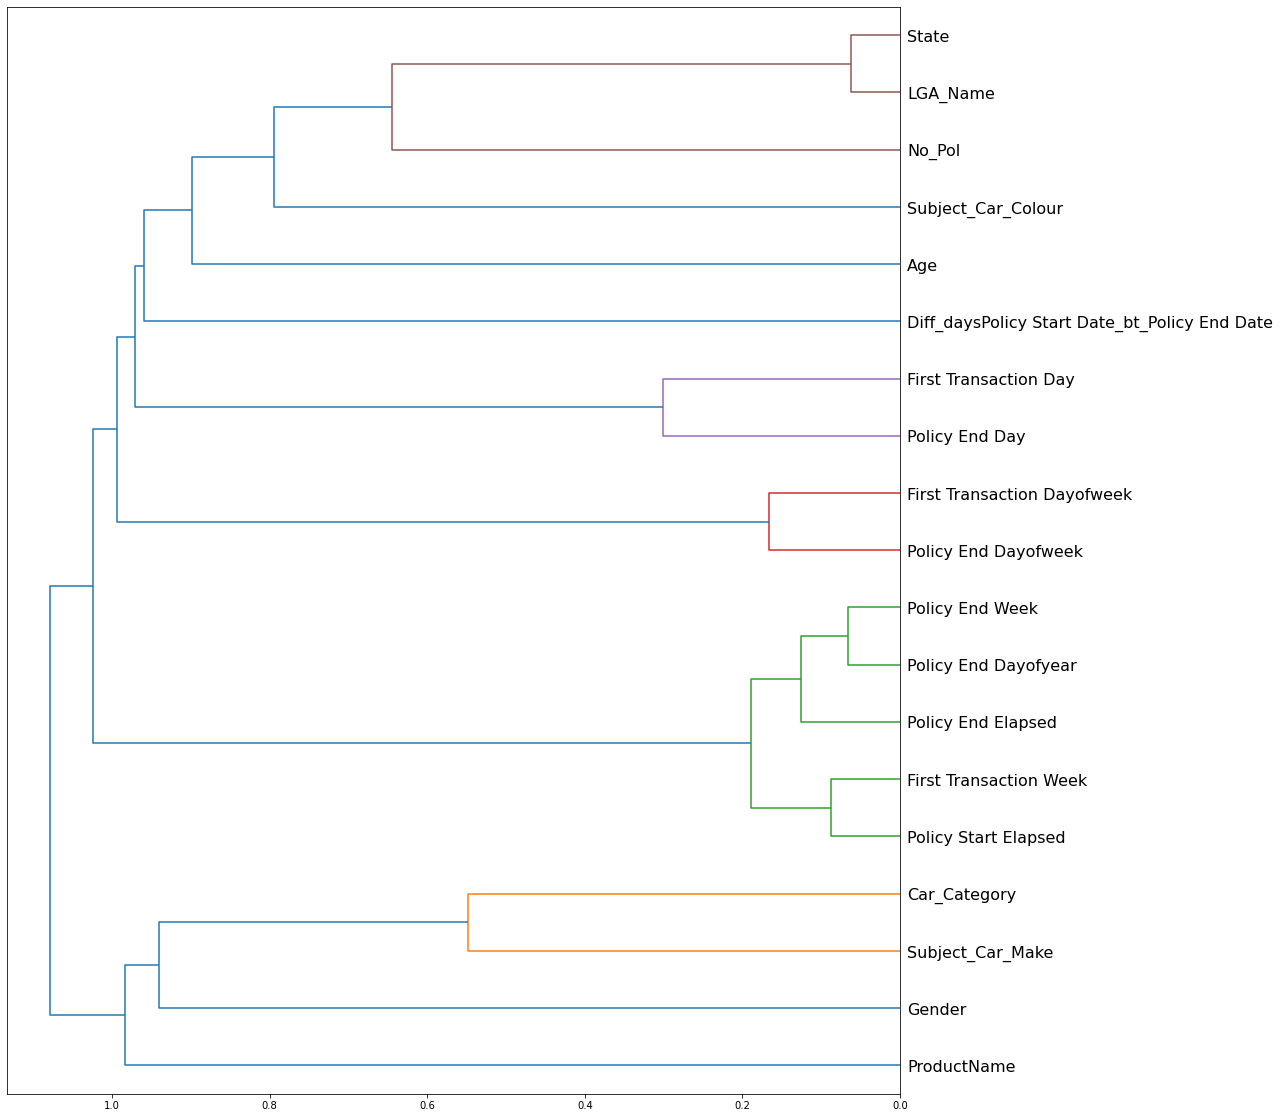

In [1268]:
corr = np.round(scipy.stats.spearmanr(X_train[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=X_train[to_keep].columns, orientation='left', leaf_font_size=16)
plt.show()

In [1269]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [1270]:
imp

,feature,importance
3,Subject_Car_Make,0.12601
0,ProductName,0.09445
1,Age,0.07143
5,Subject_Car_Colour,0.00724
12,Car_Category,0.00530
16,First Transaction Dayofweek,0.00455
11,Gender,0.00426
10,Policy End Dayofweek,0.00327
13,No_Pol,0.00264
17,Policy End Week,0.00257


In [1271]:
imp[imp.importance<0]

,feature,importance
18,First Transaction Week,-0.00050
15,Diff_daysPolicy Start Date_bt_Policy End Date,-0.00063
6,State,-0.00121
8,Policy End Elapsed,-0.00390
2,LGA_Name,-0.00960


In [1272]:
to_keep = list(imp[imp.importance >= 0].feature)

In [1273]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [1274]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.36830357142857145


array([[1685,  516],
       [  50,  165]])

In [1275]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [1276]:
imp

,feature,importance
0,Subject_Car_Make,0.13108
1,ProductName,0.10074
2,Age,0.05595
3,Subject_Car_Colour,0.00272
5,First Transaction Dayofweek,0.00056
13,Policy Start Elapsed,0.00000
4,Car_Category,-0.00165
6,Gender,-0.00195
7,Policy End Dayofweek,-0.00218
11,Policy End Dayofyear,-0.00285


In [1277]:
to_keep = list(imp[imp.importance >= 0].feature)

In [1278]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [1279]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.38297872340425526


array([[1732,  469],
       [  53,  162]])

In [1280]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [1281]:
imp

,feature,importance
0,Subject_Car_Make,0.13673
1,ProductName,0.09815
2,Age,0.07662
3,Subject_Car_Colour,0.01991
4,First Transaction Dayofweek,0.01507
5,Policy Start Elapsed,0.00000


In [1282]:
to_keep = list(imp[imp.importance >= 0].feature)

In [1283]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [1284]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3767772511848341


array([[1731,  470],
       [  56,  159]])

In [1285]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [1286]:
imp

,feature,importance
0,Subject_Car_Make,0.14223
1,ProductName,0.10512
2,Age,0.06843
4,First Transaction Dayofweek,0.01416
3,Subject_Car_Colour,0.01131
5,Policy Start Elapsed,0.00000


In [1287]:
to_keep = list(imp[imp.importance >= 0].feature)

In [1288]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [1289]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3813953488372093


array([[1720,  481],
       [  51,  164]])

In [1290]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [1291]:
imp

,feature,importance
0,Subject_Car_Make,0.14174
1,ProductName,0.09904
2,Age,0.07239
4,Subject_Car_Colour,0.01477
3,First Transaction Dayofweek,0.01250
5,Policy Start Elapsed,0.00000


In [1292]:
to_keep = list(imp[imp.importance >= 0].feature)

In [1293]:
X_train= X_train[to_keep]
X_val = X_val[to_keep]

In [1294]:
m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 600, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_val)
print(f'f1 score {f1_score(y_val,y_pred)}')
confusion_matrix(y_val,y_pred)

Training model
f1 score 0.3888888888888889


array([[1720,  481],
       [  47,  168]])

In [1295]:
imp = pimp_feat_importance(m, X_val, y_val, 
                                        scoring = 'f1')

In [1296]:
imp

,feature,importance
0,Subject_Car_Make,0.14672
1,ProductName,0.10512
2,Age,0.08119
4,First Transaction Dayofweek,0.02060
3,Subject_Car_Colour,0.01727
5,Policy Start Elapsed,0.00000


In [1297]:
imp.to_csv(path/'data/raw/feature_importance_perm.csv')

In [1298]:
list(imp.feature)

['Subject_Car_Make',
 'ProductName',
 'Age',
 'First Transaction Dayofweek',
 'Subject_Car_Colour',
 'Policy Start Elapsed']

In [1299]:
df_train_keep = X_train.copy()

In [1300]:
df_train_keep['target'] = y_train

In [1301]:
df_val_keep = X_val.copy()

In [1302]:
df_val_keep['target'] = y_val

In [1303]:
df_train_keep.to_feather(path/'data/ready/train_keep.fth')

In [1304]:
df_val_keep.to_feather(path/'data/ready/val_keep.fth')

## Test

### Load data

In [1344]:
df_test = pd.read_csv(path/'Test.csv', parse_dates=['Policy Start Date','Policy End Date',
                                                     'First Transaction Date'])

In [1345]:
df_test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [1346]:
df_test.shape

(1202, 13)

In [1308]:
df_test.describe()

,Age,No_Pol
count,1202.00000,1202.00000
mean,43.79285,1.25790
std,19.98624,0.61351
min,-26.00000,1.00000
25%,35.00000,1.00000
50%,41.00000,1.00000
75%,50.00000,1.00000
max,120.00000,7.00000


In [1309]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      1202 non-null   object        
 1   Policy Start Date       1202 non-null   datetime64[ns]
 2   Policy End Date         1202 non-null   datetime64[ns]
 3   Gender                  1161 non-null   object        
 4   Age                     1202 non-null   int64         
 5   First Transaction Date  1202 non-null   datetime64[ns]
 6   No_Pol                  1202 non-null   int64         
 7   Car_Category            830 non-null    object        
 8   Subject_Car_Colour      505 non-null    object        
 9   Subject_Car_Make        954 non-null    object        
 10  LGA_Name                546 non-null    object        
 11  State                   546 non-null    object        
 12  ProductName             1202 non-null   object  

In [1310]:
min(df_test['Policy Start Date'])

Timestamp('2010-01-01 00:00:00')

In [1311]:
max(df_test['Policy Start Date'])

Timestamp('2010-12-31 00:00:00')

### Data preparation

In [1312]:
df_test['Policy Start Date'] = pd.to_datetime(df_test['Policy Start Date'] )
df_test['Policy End Date'] = pd.to_datetime(df_test['Policy End Date'] )
df_test['First Transaction Date'] = pd.to_datetime(df_test['First Transaction Date'] )

In [1313]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      1202 non-null   object        
 1   Policy Start Date       1202 non-null   datetime64[ns]
 2   Policy End Date         1202 non-null   datetime64[ns]
 3   Gender                  1161 non-null   object        
 4   Age                     1202 non-null   int64         
 5   First Transaction Date  1202 non-null   datetime64[ns]
 6   No_Pol                  1202 non-null   int64         
 7   Car_Category            830 non-null    object        
 8   Subject_Car_Colour      505 non-null    object        
 9   Subject_Car_Make        954 non-null    object        
 10  LGA_Name                546 non-null    object        
 11  State                   546 non-null    object        
 12  ProductName             1202 non-null   object  

In [1314]:
df_test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


#### Adding timedelta

In [1315]:
timedelta_with_general_date(df_test, 'Policy Start Date',drop = False)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Diff_daysPolicy Start Date_bt_Policy End Date,Diff_monthPolicy Start Date_bt_Policy End Date,Diff_yearPolicy Start Date_bt_Policy End Date,Diff_daysPolicy Start Date_bt_First Transaction Date,Diff_monthPolicy Start Date_bt_First Transaction Date,Diff_yearPolicy Start Date_bt_First Transaction Date
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
1198,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
1199,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000
1200,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,-364.00000,-12.00000,-1.00000,0.00000,0.00000,0.00000


In [1316]:
date_cols = df_test.select_dtypes(include = ['datetime64[ns]']).columns

In [1317]:
for date in date_cols:
    add_datepart(df_test,date,drop=False)

In [1318]:
date_cols

Index(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], dtype='object')

In [1319]:
df_test.drop(columns = date_cols, inplace = True)

#### Encode categoricals

In [1320]:
with open(path/'CatPrep.pkl', 'rb') as f:
    EncodeCategorical = pickle.load(f)

In [1321]:
df_test.drop(columns='ID').select_dtypes(include='object').head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,Female,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,Male,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,Female,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,Female,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,NaN,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [1322]:
for i in list(EncodeCategorical.categories):
    if i not in df_test.columns:
        EncodeCategorical.categories.pop(i)
EncodeCategorical.cat_names = list(EncodeCategorical.categories)

In [1323]:
EncodeCategorical(df_test,test=True)

In [1324]:
df_test[cat_cols].head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,2,0,0,21,16,8,2
1,4,0,0,0,146,23,2
2,2,9,5,25,240,7,2
3,2,9,0,64,0,0,6
4,0,9,33,27,235,71,2


#### Fixmissing

In [1325]:
# with open(path/'FixMiss.pkl', 'rb') as f:
#     FixMiss = pickle.load(f)

In [1326]:
df_test.isnull().sum().sum()

0

In [1327]:
df_preds = df_test.copy()

#### Save ready_test

In [1328]:
df_test= df_test[to_keep]

In [1329]:
df_test.reset_index(inplace = True, drop = True)

In [1330]:
df_test.head()

,Subject_Car_Make,ProductName,Age,Subject_Car_Colour,First Transaction Dayofweek,Policy Start Elapsed
0,21,2,46,0,5,1287792000.00000
1,0,2,32,0,3,1287014400.00000
2,25,2,45,5,6,1283040000.00000
3,64,6,58,0,6,1276387200.00000
4,27,2,120,33,3,1277942400.00000


In [1331]:
df_test.to_csv(path/'data/ready/test.fth')

In [1332]:
X_test = df_test.copy()

## Predict

In [1333]:
df_train = pd.read_feather(path/'data/ready/train_keep.fth')

In [1334]:
df_val = pd.read_feather(path/'data/ready/val_keep.fth')

In [1335]:
frames = [df_train,df_val]

df_full =pd.concat(frames)

In [1336]:
X_train = df_full[to_keep]

In [1337]:
X_test = df_test[to_keep]

In [1338]:
y_train = df_full.target

In [1339]:
m =BalancedRandomForestClassifier(n_jobs=-1, n_estimators = 800, min_samples_leaf = 3,
                           criterion='entropy',
                           max_features= 0.9)
print(f'Training model')
m.fit(X_train, y_train)
y_pred =  m.predict(X_test)

Training model


In [1340]:
df_preds['target'] = y_pred

In [1341]:
df_preds.target.value_counts()

0    721
1    481
Name: target, dtype: int64

In [1342]:
df_preds[['ID','target']].to_csv('29042021.csv', index=False)

In [1343]:
pkl_filename = path/"models/brf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m, file)